- ~~start off with a nice map with the selected bounding box.~~
- show the code, but emphasize what is happening in the code, not talk
about the actual code
- talk about how notebooks like this not only demonstrate the process,
but can be copied and modified by others (like we did already
inundation on east coast => sea water temperature in Boston => sensor
data near Endurance
- deal with the all the models found (plot meshes? data?)
- add the "named" lines.
- share env

## Can we get data near the [Coastal Endurance](http://oceanobservatories.org/array/coastal-endurance/) array?

![](http://oceanobservatories.org/wp-content/uploads/2011/04/Endurance-Array-Map_2013_04-17_ver_0-02.jpg)

(a) Bounding box: everything inside the Oregon Line (44&deg;35'N, 125&deg;W) and Washington Line (47&deg;N, 125&deg;W).

In [1]:
bbox = [-127, 43, -123.75, 48]

(b) Time span to get the data: &plusmn;5 days.

In [2]:
from datetime import datetime, timedelta

dt = 5

date = datetime.utcnow()  # Uncomment to use now.
start = date - timedelta(days=dt)
stop = date + timedelta(days=dt)

In [3]:
from owslib import fes


def fes_date_filter(start, stop):
    """
    Take datetime-like objects and returns a fes filter for date range
    (begin and end inclusive).
    NOTE: Truncates the minutes!!!
    
    """
    start = start.strftime('%Y-%m-%d %H:00')
    stop = stop.strftime('%Y-%m-%d %H:00')

    propertyname = 'apiso:TempExtent_begin'
    begin = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                            literal=stop)
    propertyname = 'apiso:TempExtent_end'
    end = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                             literal=start)
    return begin, end

In [4]:
begin, end = fes_date_filter(start, stop)

(c) Variable: `sea water temperature`.

In [5]:
sos_name = 'sea_water_temperature'

# These are CF standard names.  But we can uses non-CF like 'Water Temperature'
# and that will return more datasets.
name_list = ['sea_water_temperature',
             'sea_surface_temperature',
             'sea_water_potential_temperature',
             'equivalent_potential_temperature',
             'sea_water_conservative_temperature',
             'pseudo_equivalent_potential_temperature']

Assemble `fes` filter with `a`+`b`+`c`.

In [6]:
kw = dict(wildCard='*',
          escapeChar='\\',
          singleChar='?',
          propertyname='apiso:AnyText')

or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                  for val in name_list])

filter_list = [fes.And([begin, end, fes.BBox(bbox), or_filt])]

Instantiate `csw` object using the NGDC catalog.

In [7]:
from owslib.csw import CatalogueServiceWeb

csw = CatalogueServiceWeb('http://www.ngdc.noaa.gov/geoportal/csw',
                          timeout=60)

csw.getrecords2(constraints=filter_list, maxrecords=1000, esn='full')

fmt = '{:*^64}'.format
print(fmt(' Catalog information '))
print("CSW version: {}".format(csw.version))
print("Number of datasets available: {}".format(len(csw.records.keys())))

********************* Catalog information **********************
CSW version: 2.0.2
Number of datasets available: 7


What did we get?

In [8]:
def service_urls(records, service='odp:url'):
    """
    Extract service_urls of a specific type (DAP, SOS) from csw records.
    """
    service_string = 'urn:x-esri:specification:ServiceType:' + service
    urls = []
    for key, rec in records.items():
        # Create a generator object, and iterate through it until the match is
        # found if not found, gets the default value (here "none").
        url = next((d['url'] for d in rec.references if
                    d['scheme'] == service_string), None)
        if url is not None:
            urls.append(url)
    urls = sorted(set(urls))
    return urls

In [9]:
dap_urls = service_urls(csw.records, service='odp:url')
sos_urls = service_urls(csw.records, service='sos:url')

print(fmt(' SOS '))
for url in sos_urls:
    print('{}'.format(url))

print(fmt(' DAP '))
for url in dap_urls:
    print('{}.html'.format(url))

***************************** SOS ******************************
http://data.nanoos.org/52nsos/sos/kvp?service=SOS&request=GetCapabilities&acceptVersions=1.0.0
http://sdf.ndbc.noaa.gov/sos/server.php?service=SOS&request=GetCapabilities&acceptVersions=1.0.0
***************************** DAP ******************************
http://amb6400b.stccmop.org:8080/thredds/dodsC/model_data/forecast.html
http://oos.soest.hawaii.edu/thredds/dodsC/hioos/satellite/dhw.html
http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global.html
http://thredds.axiomdatascience.com/thredds/dodsC/CA_DAS.nc.html


In [10]:
import copy
from io import BytesIO

from owslib.ows import ExceptionReport
from pandas import DataFrame, read_csv


def collector2table(collector, col='sea_water_temperature (C)'):
    c = copy.copy(collector)
    c.features = None
    try:
        response = c.raw(responseFormat="text/csv")
    except ExceptionReport:
        response = c.filter(end=c.start_time).raw(responseFormat="text/csv")

    df = read_csv(BytesIO(response.encode('utf-8')),
                  parse_dates=True)
    g = df.groupby('station_id')
    df = dict()
    for station in g.groups.keys():
        df.update({station: g.get_group(station).iloc[0]})
    df = DataFrame.from_dict(df).T
    
    names = []
    for sta in df.index:
        names.extend([offering.description for offering in c.server.offerings if sta == offering.name])
    df['name'] = names
    
    observations = []
    for k, row in df.iterrows():
        station_id = row['station_id'].split(':')[-1]
        c.features = [station_id]
        response = c.raw(responseFormat="text/csv")
        kw = dict(parse_dates=True, index_col='date_time')
        data = read_csv(BytesIO(response.encode('utf-8')), **kw).reset_index()
        data = data.drop_duplicates(subset='date_time').set_index('date_time')
        
        series = data[col]
        series._metadata = [dict(name=row['name'],
                                 station=row['station_id'],
                                 sensor=row['sensor_id'],
                                 lon=row['longitude (degree)'],
                                 lat=row['latitude (degree)'],
                                 depth=row['depth (m)'],)]

        observations.append(series)
    return observations

In [11]:
from pyoos.collectors.ndbc.ndbc_sos import NdbcSos
from pyoos.collectors.ioos.swe_sos import IoosSweSos
from pyoos.collectors.coops.coops_sos import CoopsSos

observations = []
for url in sos_urls:
    if 'co-ops' in url.lower():
        collector = CoopsSos()
    elif 'ndbc' in url.lower():
        collector = NdbcSos()
    else:
        collector = IoosSweSos(url)
    
    collector.set_bbox(bbox)
    collector.end_time = stop
    collector.start_time = start
    collector.variables = [sos_name]
    
    ofrs = collector.server.offerings
    title = collector.server.identification.title
    try:
        observations.extend(collector2table(collector))
        print(fmt(' {} '.format(url)))
        print('{}: {} offerings\n'.format(title, len(ofrs)))
    except Exception as e:
        print('\nCannot collect:\n{}. {}'.format(url, e))


Cannot collect:
http://data.nanoos.org/52nsos/sos/kvp?service=SOS&request=GetCapabilities&acceptVersions=1.0.0. 
 http://sdf.ndbc.noaa.gov/sos/server.php?service=SOS&request=GetCapabilities&acceptVersions=1.0.0 
National Data Buoy Center SOS: 964 offerings



Let's take a look at the data we found.

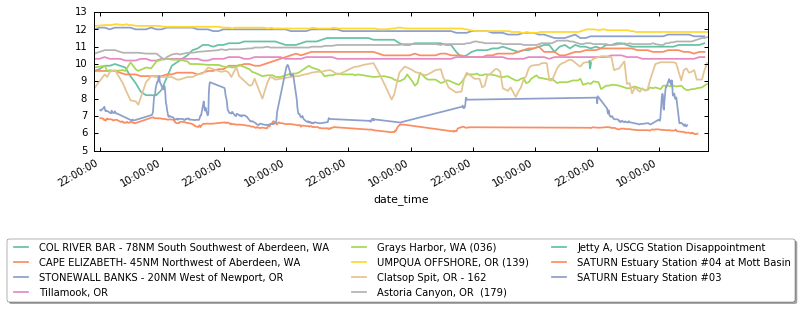

In [12]:
%matplotlib inline
from itertools import cycle
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np


def mpl_palette(cmap, n_colors=6):
    brewer_qual_pals = {"Accent": 8, "Dark2": 8, "Paired": 12,
                        "Pastel1": 9, "Pastel2": 8,
                        "Set1": 9, "Set2": 8, "Set3": 12}

    if cmap.name in brewer_qual_pals:
        bins = np.linspace(0, 1, brewer_qual_pals[cmap.name])[:n_colors]
    else:
        bins = np.linspace(0, 1, n_colors + 2)[1:-1]
    palette = list(map(tuple, cmap(bins)[:, :3]))

    pal_cycle = cycle(palette)
    palette = [next(pal_cycle) for _ in range(n_colors)]
    
    return palette

with mpl.style.context('seaborn-notebook'):
    fig, ax = plt.subplots(figsize=(11, 2.75))
    colors = mpl_palette(plt.cm.Set2, n_colors=len(observations))
    for k, series in enumerate(observations):
        station_name = series._metadata[0]['name']
        series.plot(ax=ax, label=station_name, color=colors[k])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6),
          ncol=3, fancybox=True, shadow=True)

Now that we have all the pieces let's create an interactive map with all this information.

First the `Map` object.

In [13]:
import folium
import numpy as np

location = np.array(bbox).reshape(2, 2).mean(axis=0).tolist()[::-1]
tiles = ('http://services.arcgisonline.com/arcgis/rest/'
         'services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}')

mapa = folium.Map(location=location, zoom_start=6, tiles=tiles, attr='ESRI')

The time-series (as html `bokeh` plots).

In [14]:
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html

from folium.element import IFrame

def make_marker(series):
    width, height = 500, 250
    metadata = series._metadata[0]
    
    p = figure(x_axis_type="datetime",
               title=metadata['name'],
               width=width, height=height)
    p.line(series.index, series, line_width=2)
    html = file_html(p, CDN, metadata['station'].split(':')[-1])
    iframe = IFrame(html, width=width+40, height=height+80)
    
    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(location=[metadata['lat'], metadata['lon']],
                           popup=popup,
                           icon=icon)
    return marker

for series in observations:
    make_marker(series).add_to(mapa)

A region bounding box.

In [15]:
box = folium.PolyLine([[bbox[1], bbox[0]], [bbox[1], bbox[2]],
                       [bbox[3], bbox[2]], [bbox[3], bbox[0]],
                       [bbox[1], bbox[0]]], color='red')
box.add_to(mapa)

Add the models meshes as a raster layer.

In [16]:
from folium import plugins
from netCDF4 import Dataset
from gridgeo import GridGeo, rasterize

for url in dap_urls:
    # Drop the global model.
    if 'global' not in url and 'satellite' not in url:
        with Dataset(url) as nc:
            grid = GridGeo(nc)
            gj = folium.GeoJson(grid.outline.__geo_interface__)
            gj.add_children(folium.Popup(getattr(nc, 'summary', url)))
            mapa.add_children(gj)

Finally the full map:

In [17]:
mapa